In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch
from tqdm.auto import tqdm

tensor(0.8304)


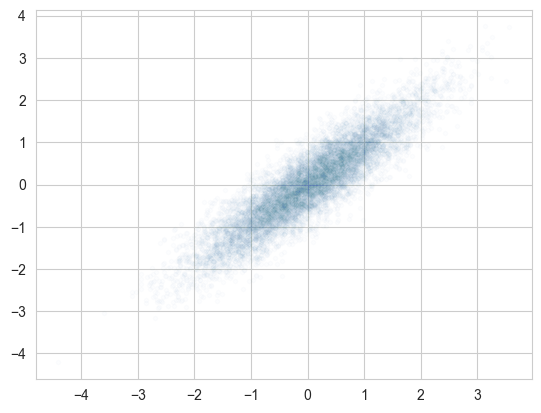

In [2]:
# Make a multivariate gaussian distribution
from torch.distributions import MultivariateNormal

rho = 0.9
cov = torch.tensor([[1, rho], [rho, 1.]])
mean = torch.tensor([0., 0.])
x_dim = y_dim = n_dim = 1

p_xy = MultivariateNormal(
    mean.unsqueeze(0).repeat(n_dim,1), 
    cov.unsqueeze(0).repeat(n_dim,1,1))

samples = p_xy.sample([10000])

plt.scatter(
    samples.reshape(-1,2)[:,0], 
    samples.reshape(-1,2)[:, 1],
    marker='.',
    alpha=0.01
)

# plt.ylim(-20,20)


true_mi = (MultivariateNormal(mean, torch.eye(2)).entropy() - p_xy.entropy()).sum()
print(true_mi)

In [3]:
# from torch_mist.ratio import SeparableUnnormalizedRatioEstimator, JointRatioEstimatorMLP
from torch_mist.distributions.utils import conditional_transformed_normal, transformed_normal
# from torch_mist.distributions.transforms import ConditionalTransformedDistributionModule
from torch.distributions import Normal
# from torch_mist.cr import SeparableUnnormalizedRatioEstimator


entropy_y = Normal(0,1).entropy()*n_dim

q_y = transformed_normal(
    input_dim=y_dim,
    hidden_dims=[64],
    transform_name='linear',
    n_transforms=1,
)

q_y_x = conditional_transformed_normal(
    input_dim=y_dim,
    context_dim=x_dim,
    hidden_dims=[64],
    transform_name='conditional_linear',
    n_transforms=1,
)


# projection_head = torch.nn.Sequential(
#         torch.nn.Linear(n_dim, 128),
#         torch.nn.ReLU(),
#         torch.nn.Linear(128, 64),
#     )

# separable_ratio_estimator = SeparableUnnormalizedRatioEstimator(
#     f_x=projection_head,
#     f_y=projection_head,
# )

# joint_ratio_estimator = JointRatioEstimatorMLP(
#     x_dim=n_dim,
#     y_dim=n_dim,
#     hidden_dims=[128, 64]
# )


# separable_ratio_estimator, joint_ratio_estimator

q_y

TransformedDistributionModule(
  (base_dist): Normal()
  (transforms): ModuleList(
    (0): Linear()
  )

In [4]:
from torch.optim import AdamW
from torch_mist.utils.data import SampleDataLoader

trainloader = SampleDataLoader(
    p_xy, 
    batch_size=64,
    max_samples=100000
)

testloader = SampleDataLoader(
    p_xy, 
    batch_size=64,
    max_samples=10000,
)


log = []
iteration = 0
batch_size = 64


In [5]:
from torch_mist.quantization import VQVAE, LearnableVectorQuantization
from pyro.nn import DenseNN

z_dim = 10
n_bins = 128
mc_samples = 16
hidden_dims = [64]
x_dim = y_dim = n_dim

quantization = LearnableVectorQuantization(
    net=DenseNN(y_dim, hidden_dims, [z_dim]),
    quantization_dim=z_dim,
    n_bins=n_bins
)

model = VQVAE(
    encoder=quantization,
    decoder=conditional_transformed_normal(
        input_dim=x_dim,
        context_dim=z_dim,
        transform_name='conditional_linear',
        transform_params={'scale': 0.1}
    ),
    cross_modal=True,
    beta=0.2
)

# VQVAE(
#     encoder=
#     decoder=conditional_transformed_normal(
#         input_dim=x_dim,
#         context_dim=z_dim,
#         transform_name='conditional_linear',
# #         transform_params={'scale': 0.1}
#     ),
#     n_bins=n_bins,
#     z_dim=z_dim,
#     cross_modal=False,
#     beta=0.2
# )



In [6]:
from torch.optim import Adam

opt = Adam(model.parameters(), lr=1e-3)

log = []
iteration = 0
xs = []
ys = []

In [7]:

for epoch in range(3):
    for x, y in tqdm(trainloader):
        loss = model.loss(x,y)
        xs.append(x)
        ys.append(y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        log.append({
            'loss': loss.item(),
            'iteration': iteration
        })
        iteration += 1

xs = torch.cat(xs,0)
ys = torch.cat(ys,0)

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

<Axes: xlabel='iteration'>

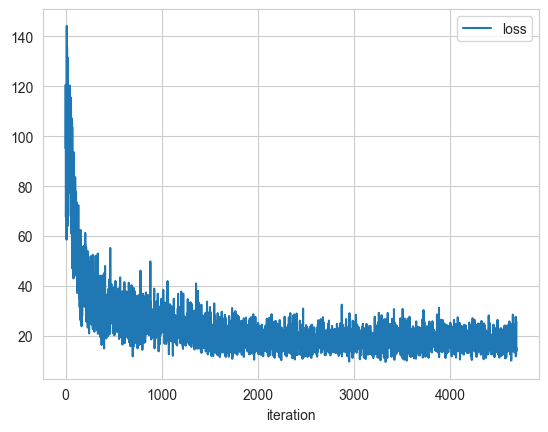

In [8]:
pd.DataFrame(log).plot(x='iteration')

In [9]:
z = model.encoder.net(x)
indices = model.encoder.codebook_lookup(z)

# Compute the one-hot representation of the indices [N*M, n_bins]
flat_indices = indices.view(-1)
one_hot = torch.nn.functional.one_hot(flat_indices,n_bins).float()

# Compute the number of datapoints assigned to each bin [n_bins]
assignments = one_hot.mean(0)


# Compute the mean vector for each assignment [n_bins, z_dim]
mean_vector = (one_hot.unsqueeze(-1) * z.unsqueeze(1)).sum(0)
mean_vector = mean_vector / (assignments.unsqueeze(-1) * flat_indices.shape[0])
# mean_vector[torch.isnan(mean_vector)] = quantization.vectors[torch.isnan(mean_vector)]



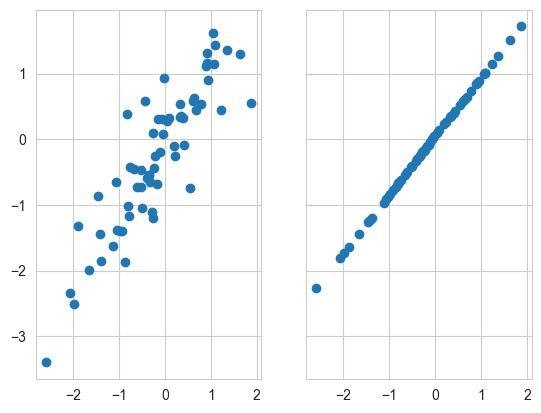

In [10]:
x_ = model.decoder.condition(z).sample()

f, ax =plt.subplots(1,2, sharex=True, sharey=True)
ax[0].scatter(x,y)
ax[1].scatter(x,x_)

In [11]:
mean_vector.shape

torch.Size([128, 10])

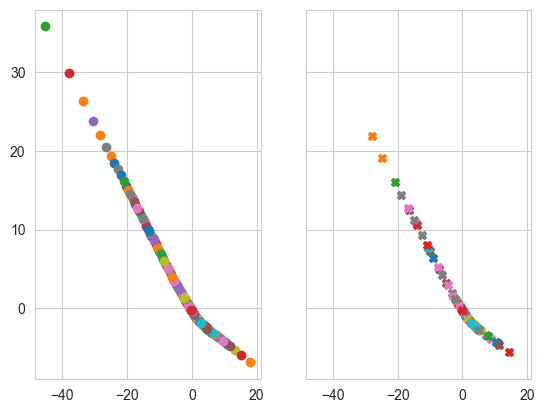

In [12]:

f, ax = plt.subplots(1,2, sharex=True, sharey=True)
for i in range(n_bins):
    ax[0].plot(quantization.vectors[i,0].item(), quantization.vectors[i,1].item(), 'o')
    ax[1].plot(mean_vector[i,0].item(), mean_vector[i,1].item(), 'X')
    
z = model.encoder.net(x)
for i in range(n_bins):
    ax[0].scatter(
        z[indices[:,0]==i,0].data.numpy(),
        z[indices[:,0]==i,1].data.numpy(), 
        marker='.', alpha=0.1
    )
    ax[1].scatter(
        z[indices[:,0]==i,0].data.numpy(),
        z[indices[:,0]==i,1].data.numpy(), 
        marker='.', alpha=0.1
    )

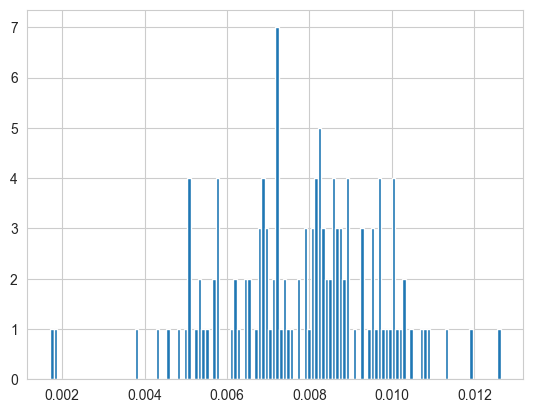

In [13]:
plt.hist(model.assignments.data.numpy(), bins=n_bins);


In [14]:
probs = model.assignments/model.assignments.sum()
probs = probs.data.numpy()

-np.sum(probs * np.log(probs)), np.log(n_bins)

(4.821164, 4.852030263919617)

In [29]:
from torch_mist.distributions.utils import conditional_categorical
from torch_mist.quantization import LearnableQuantization, FixedQuantization
from torch_mist.quantization import trained_vector_quantization
from pyro.nn import DenseNN
import torch



# quantization = LearnableQuantization(
#     DenseNN(
#         y_dim,
#         hidden_dims,
#         [n_bins],
#     ),
#     n_bins
# )

n_bins=16
min_value=-3
max_value=3
thresholds=torch.linspace(min_value, max_value, n_bins-1) 

quantization = FixedQuantization(x_dim, thresholds)

quantization = trained_vector_quantization(
    trainloader,
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=hidden_dims+[4],
    n_bins=n_bins,
    n_train_epochs=5,
)
d_q_y_x = conditional_categorical(
    n_classes=quantization.n_bins,
    context_dim=x_dim,
    hidden_dims=hidden_dims,
)

quantization, d_q_y_x

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

(LearnableVectorQuantization(
   (net): DenseNN(
     (layers): ModuleList(
       (0): Linear(in_features=1, out_features=64, bias=True)
       (1): Linear(in_features=64, out_features=4, bias=True)
     )
     (f): ReLU()
   )
 ),
 ConditionalCategorical(
   (net): DenseNN(
     (layers): ModuleList(
       (0): Linear(in_features=1, out_features=64, bias=True)
       (1): Linear(in_features=64, out_features=16, bias=True)
     )
     (f): ReLU()
   )
 ))

In [30]:
from torch_mist.quantization import QuantizationFunction


In [31]:
from torch_mist.estimators.discriminative import nwj, infonce, tuba, alpha_tuba, flo, js, mine, smile
from torch_mist.estimators.generative import ba, doe, gm, l1out, club
from torch_mist.estimators.hybrid import HybridMutualInformationEstimator
from torch_mist.baselines import LearnableBaseline, LearnableJointBaseline
from torch_mist.estimators.generative.pq import PQ
from torch import nn
from copy import deepcopy



estimators = {
# # Discriminative Estimators
#     'NWJ': nwj(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         mc_samples=mc_samples
#     ),
#     'InfoNCE': infonce(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#     ),
#     'JS': js(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         mc_samples=mc_samples
#     ),
#     'MINE': mine(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         mc_samples=mc_samples
#     ),
#     'SMILE': smile(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         mc_samples=mc_samples
#     ),
#     'TUBA': tuba(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         mc_samples=mc_samples
#     ),
#     'AlphaTUBA': alpha_tuba(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         mc_samples=mc_samples
#     ),
#      'FLO': flo(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         mc_samples=mc_samples
#     ),
# Generative Estimators
#     'BA': ba(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         entropy_y=entropy_y,
#         hidden_dims=hidden_dims,
#         transform_name='conditional_linear',
#         n_transforms=1
#     ),
#     'DoE': doe(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         conditional_transform_name='conditional_linear',
#         n_conditional_transforms=1,
#         marginal_transform_name='linear',
#         n_marginal_transforms=1,
#     ),
#     'GM': gm(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         joint_transform_name='affine_autoregressive',
#         n_joint_transforms=2,
#         marginal_transform_name='linear',
#         n_marginal_transforms=1,
#     ),

    'PQ': PQ(
        conditional_qy_x=d_q_y_x,
        quantization=quantization
    ),
#     'L1Out': l1out(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         transform_name='conditional_linear',
#         n_transforms=1
#     ),
#     'CLUB': club(
#         x_dim=x_dim,
#         y_dim=y_dim,
#         hidden_dims=hidden_dims,
#         transform_name='conditional_linear',
#         n_transforms=1
#     ),
}
estimators

{'PQ': PQ(
   (quantization): LearnableVectorQuantization(
     (net): DenseNN(
       (layers): ModuleList(
         (0): Linear(in_features=1, out_features=64, bias=True)
         (1): Linear(in_features=64, out_features=4, bias=True)
       )
       (f): ReLU()
     )
   )
   (conditional_qy_x): ConditionalCategorical(
     (net): DenseNN(
       (layers): ModuleList(
         (0): Linear(in_features=1, out_features=64, bias=True)
         (1): Linear(in_features=64, out_features=16, bias=True)
       )
       (f): ReLU()
     )
   )
 )}

In [32]:
for name, param in q_y_x.named_parameters():
    print(name, param.shape)

transforms.0.nn.layers.0.weight torch.Size([64, 1])
transforms.0.nn.layers.0.bias torch.Size([64])
transforms.0.nn.layers.1.weight torch.Size([2, 64])
transforms.0.nn.layers.1.bias torch.Size([2])


In [33]:
import time
from torch_mist.utils.estimate import optimize_mi_estimator
from torch.optim import AdamW
log = pd.DataFrame()

for name, estimator in tqdm(estimators.items()):
    print(name)
    start_time = time.time()
    partial_log = optimize_mi_estimator(
        estimator=estimator, 
        dataloader=trainloader,
        optimizer_params={'lr': 1e-3},
        optimizer_class=AdamW
    )
    partial_log['estimator'] = name
    log = pd.concat([log, partial_log])
    
    print(time.time()-start_time)
    

  0%|          | 0/1 [00:00<?, ?it/s]

PQ


  0%|          | 0/1562 [00:00<?, ?it/s]

2.293492317199707


In [34]:
for x,y in trainloader:
    break

x.shape, y.shape

(torch.Size([64, 1]), torch.Size([64, 1]))

In [35]:
q_y.log_prob(y.unsqueeze(1)).shape

torch.Size([64, 1])

In [36]:
# for x,y in tqdm(trainloader):
#     total_loss = 0
#     for name, estimator in estimators.items():
#         estimation = estimator(x, y)

#         loss = estimation.loss
#         total_loss  = total_loss + loss

#         entry = {
#             'value': estimation.value.item(),
#             'loss': estimation.loss.item(),
#         }

#         entry['iteration'] = iteration
#         entry['name'] = name
#         log.append(entry)

#     opt.zero_grad()
#     total_loss.backward()
#     opt.step()
#     iteration += 1


In [37]:
x = []
y = []
for x_, y_ in trainloader:
    x.append(x_)
    y.append(y_)
    
x = torch.cat(x, 0)
y = torch.cat(y, 0)



In [38]:
np.arange(x.shape[0])[x[:,0]>2.0]

array([   33,    36,   101, ..., 99902, 99929, 99941])

tensor(2.7279, grad_fn=<NegBackward0>)


<BarContainer object of 16 artists>

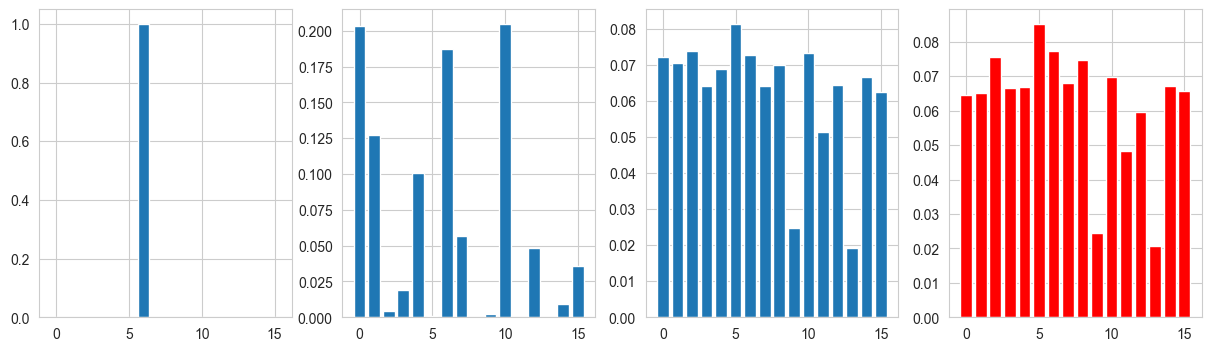

In [39]:
p_qy_y = quantization(y.unsqueeze(1))
p_qy = p_qy_y.mean(0).mean(0)

r_qy = estimators['PQ'].qy_logits/estimators['PQ'].temperature
log_r_qy = r_qy - torch.logsumexp(r_qy,-1, keepdims=True)
r_qy = log_r_qy.exp()

r_qy_x = estimators['PQ'].conditional_qy_x.condition(x).probs


h_qy = -(r_qy*log_r_qy).sum()
print(h_qy)


f, ax = plt.subplots(1,4, figsize=(15,4))
ax[0].bar(np.arange(p_qy_y.shape[-1]), p_qy_y[59,0,:].data.numpy())
ax[1].bar(np.arange(p_qy_y.shape[-1]), r_qy_x[59,0,:].data.numpy())
ax[2].bar(np.arange(p_qy_y.shape[-1]), p_qy.data.numpy())
ax[3].bar(np.arange(p_qy_y.shape[-1]), r_qy.data.numpy(), color='r')


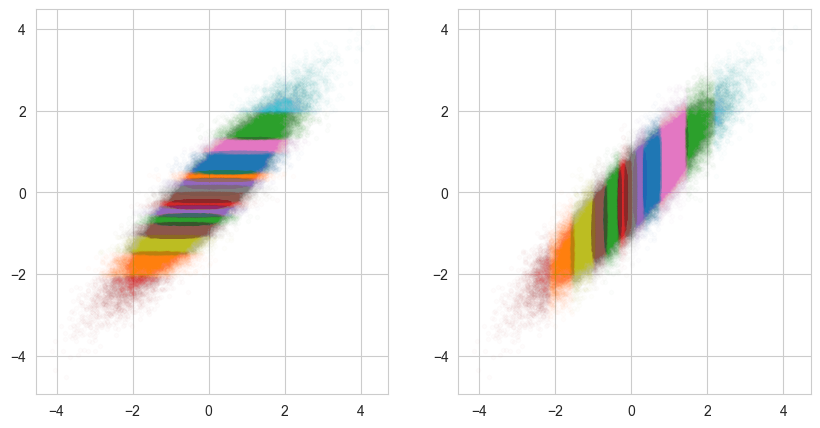

In [40]:
f, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(p_qy_y.shape[-1]):
    Q = torch.argmax(p_qy_y,-1).squeeze()
    Q_ = torch.argmax(r_qy_x, -1).squeeze()
    ax[0].plot(x[Q==i], y[Q==i], '.', alpha=0.01)
    ax[1].plot(x[Q_==i], y[Q_==i], '.', alpha=0.01)


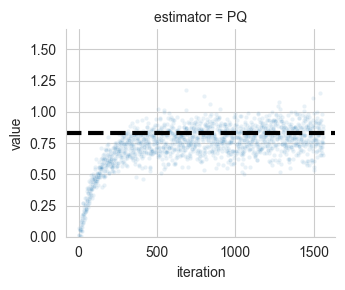

In [41]:
grid = sns.FacetGrid(pd.DataFrame(log), col='estimator', sharey=False, sharex=True, col_wrap=4)


grid.map(sns.lineplot, 'iteration', 'value', marker='.', alpha=0.1, linewidth=0)

for ax in grid.axes:
    ax.axhline(y=true_mi, ls='--', color='k', linewidth=3)
    ax.axhline(y=np.log(batch_size), ls='--', color='r', linewidth=3)
    ax.set_ylim(0, true_mi*2)

# plt.ylim(0, 1)

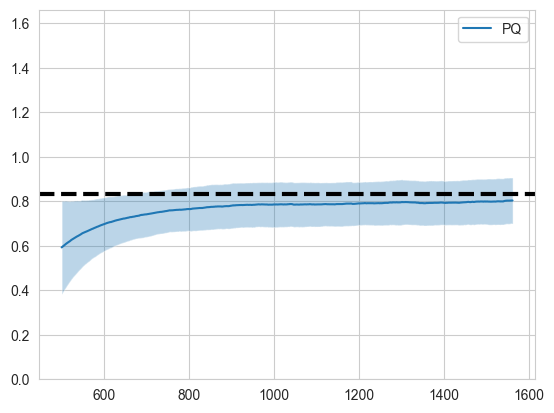

In [42]:
pd_log =pd.DataFrame(log)

window_size = 500
for name in pd_log['estimator'].unique():
    mi = pd_log[pd_log['estimator'] == name].sort_values('iteration')['value']

    # Apply a moving average
    mi_avg = mi.rolling(window_size).mean()
    mi_std = mi.rolling(window_size).std()

    plt.plot(mi_avg, label=name)
    plt.fill_between(mi_avg.index, mi_avg - mi_std, mi_avg + mi_std, alpha=0.3)
    plt.axhline(y=true_mi, ls='--', color='k', linewidth=3)
    plt.axhline(y=np.log(batch_size), ls='--', color='r', linewidth=3)
plt.ylim(0, true_mi*2)
plt.legend()

In [43]:
from torch_mist.utils.estimate import estimate_mi_std
summary = []
print(true_mi)
for name, estimator in tqdm(estimators.items()):
    mi, mi_std = estimate_mi_std(
        estimator,
        testloader
    )
    
    summary.append(
        {
            'Estimator': name,
            'Bias': (mi-true_mi.item())**2,
            'Variance':mi_std**2,
        }
    )
    print(name, mi, mi_std)

tensor(0.8304)


  0%|          | 0/1 [00:00<?, ?it/s]

PQ 0.7968265941947889 0.10923301724207071


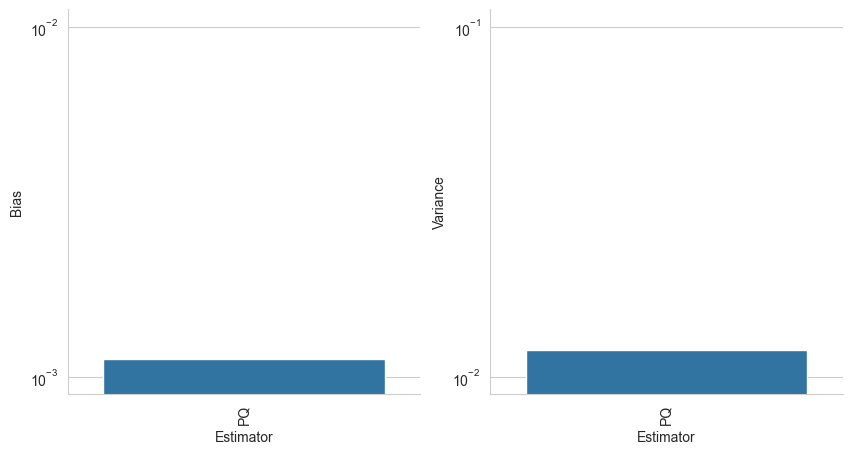

In [44]:
f, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].set_yscale('log')
ax[1].set_yscale('log')


sns.barplot(data=pd.DataFrame(summary), x='Estimator', y='Bias', ax=ax[0])
sns.barplot(data=pd.DataFrame(summary), x='Estimator', y='Variance', ax=ax[1])

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)

sns.despine()


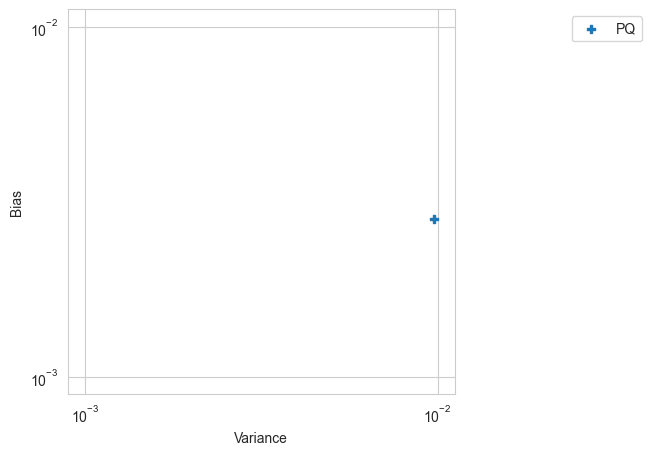

In [67]:
f, ax = plt.subplots(1,1, figsize=(5, 5))

from torch_mist.estimators.discriminative import DiscriminativeMutualInformationEstimator

ax.set_xlabel('Variance')
ax.set_ylabel('Bias')
ax.set_xscale('log')
ax.set_yscale('log')

for entry in summary:
    ax.scatter(
        entry['Variance'], 
        entry['Bias'], 
        label=entry['Estimator'],
        marker='>' if isinstance(
            estimators[entry['Estimator']], 
            DiscriminativeMutualInformationEstimator
        ) else 'P'
    )


# ax.set_ylim(1e-4,2000)

ax.legend(loc=1, bbox_to_anchor=(1.5, 1))



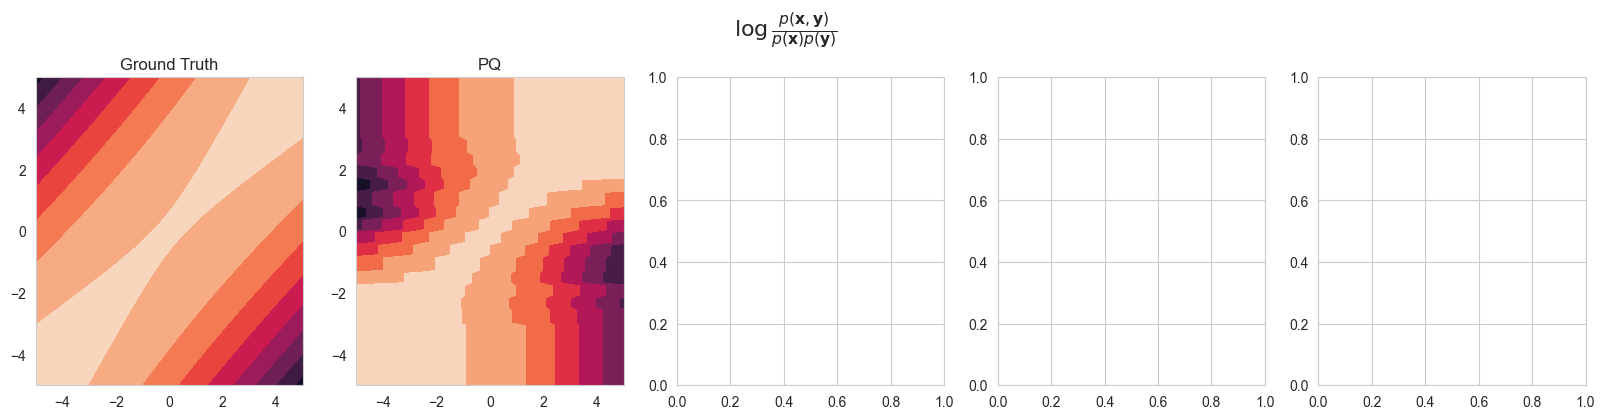

In [68]:
from torch_mist.estimators.generative import GenerativeMutualInformationEstimator

res = 100
image_size = 4
x = np.linspace(-5,5,res)
y = x

Y_grid, X_grid = np.meshgrid(x,y)
x = torch.FloatTensor(x).unsqueeze(-1).repeat(1,x_dim)
Y = torch.FloatTensor(Y_grid).unsqueeze(-1).repeat(1,1,y_dim)

log_ratio = (
    p_xy.log_prob(
        torch.FloatTensor(
            np.concatenate([
                X_grid.reshape(res,res,1),
                Y_grid.reshape(res,res,1)
            ], -1)
        ).unsqueeze(-2).repeat(1,1,n_dim,1)
    ).sum(-1) -
    Normal(0,1).log_prob(torch.FloatTensor(X_grid))*n_dim -
    Normal(0,1).log_prob(torch.FloatTensor(Y_grid))*n_dim
)

n_models = 1+len(estimators)

f, ax = plt.subplots(
    n_models//5+1,5,
    figsize=(image_size*5,image_size*(n_models//5 + 1))
)
ax = ax.reshape(-1)

f.suptitle(
    "$\\log\\frac{p({\\bf x},{\\bf y})}"\
    "{p({\\bf x})p({\\bf y})}$",
     fontsize=16, fontweight="bold",    y=1.05
)

ax[0].contourf(X_grid, Y_grid, log_ratio)
ax[0].set_title("Ground Truth")

for i, estimator_name in enumerate(estimators):
    if isinstance(estimators[estimator_name], GenerativeMutualInformationEstimator):
        log_ratio = estimators[estimator_name].log_ratio(x,Y).value.data
    else:
        log_ratio = estimators[estimator_name].unnormalized_log_ratio(x,Y).data
    
    ax[i+1].set_title(estimator_name)
    ax[i+1].contourf(X_grid, Y_grid, log_ratio)


In [107]:
x_, y_ = estimator.sample_proposal(x, y.unsqueeze(-1))
f_ = estimator.log_ratio_estimator(x_, y_)
f = estimator.log_ratio_estimator(x, y.unsqueeze(-1))
estimator.baseline(f_, x, y.unsqueeze(-1)).shape

AttributeError: 'PQ' object has no attribute 'sample_proposal'

In [12]:
f_.shape, f.shape

(torch.Size([128, 32]), torch.Size([128, 1]))

In [70]:
from pyro.distributions.transforms import conditional_affine_coupling, conditional_spline
from miest.distributions.transforms import conditional_linear
from miest.distributions.transforms import ConditionalTransformedDistributionModule
from torch.distributions import Normal, Independent

q_y_x = ConditionalTransformedDistributionModule(
    base_dist=Independent(Normal(torch.zeros(1,n_dim), torch.ones(1,n_dim)), 1),
    transforms=[
        conditional_spline(n_dim, context_dim=n_dim, hidden_dims=[32, 32]),
    ]*4
)

q_y_x

ConditionalTransformedDistributionModule(
  (transforms): ModuleList(
    (0): ConditionalSpline(
      (nn): DenseNN(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=32, bias=True)
          (2): Linear(in_features=32, out_features=310, bias=True)
        )
        (f): ReLU()
      )
    )
    (1): ConditionalSpline(
      (nn): DenseNN(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=32, bias=True)
          (2): Linear(in_features=32, out_features=310, bias=True)
        )
        (f): ReLU()
      )
    )
    (2): ConditionalSpline(
      (nn): DenseNN(
        (layers): ModuleList(
          (0): Linear(in_features=10, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=32, bias=True)
          (2): Linear(in_features=32, out_features=310, bias=True)
        

In [72]:
from miest.models.mi_estimator.generative import DoE, BA



estimators = {
    'DoE': DoE(
        conditional_y_x=deepcopy(q_y_x),
        marginal_y=ParametricNormal(torch.zeros(1,n_dim), torch.ones(1,n_dim)),
    ),
    'BA': BA(
        conditional_y_x=deepcopy(q_y_x),
        marginal_y=None,
        H_y=H_y
    ),
}

estimator

BA(
  (conditional_y_x)=ConditionalTransformedDistributionModule(  
  (transforms): ModuleList(  
    (0): ConditionalSpline(  
      (nn): DenseNN(  
        (layers): ModuleList(  
          (0): Linear(in_features=10, out_features=32, bias=True)  
          (1): Linear(in_features=32, out_features=32, bias=True)  
          (2): Linear(in_features=32, out_features=310, bias=True)  
        )  
        (f): ReLU()  
      )  
    )  
    (1): ConditionalSpline(  
      (nn): DenseNN(  
        (layers): ModuleList(  
          (0): Linear(in_features=10, out_features=32, bias=True)  
          (1): Linear(in_features=32, out_features=32, bias=True)  
          (2): Linear(in_features=32, out_features=310, bias=True)  
        )  
        (f): ReLU()  
      )  
    )  
  )  
)
)

In [73]:
for name, parameter in estimator.named_parameters():
    print(name, parameter.shape)

conditional_y_x.transforms.0.nn.layers.0.weight torch.Size([32, 10])
conditional_y_x.transforms.0.nn.layers.0.bias torch.Size([32])
conditional_y_x.transforms.0.nn.layers.1.weight torch.Size([32, 32])
conditional_y_x.transforms.0.nn.layers.1.bias torch.Size([32])
conditional_y_x.transforms.0.nn.layers.2.weight torch.Size([310, 32])
conditional_y_x.transforms.0.nn.layers.2.bias torch.Size([310])


In [74]:
from torch.optim import AdamW

opt = AdamW([{'params': estimator.parameters()} for estimator in estimators.values()], lr=5e-4)
log = []
iteration = 0
batch_size = 65

In [79]:
iterations = 10000
for _ in tqdm(range(iterations)):
    xy = p_xy.sample([batch_size, n_dim])
    x, y = xy[:, :,0], xy[:, :,1]

    total_loss = 0
    for name, estimator in estimators.items():
        estimation = estimator(x, y)

        loss = -estimation['grad']
        total_loss  = total_loss + loss

        entry = {k:v.item() for k,v in estimation.items()}
        entry['iteration'] = iteration
        entry['name'] = name
        log.append(entry)

    opt.zero_grad()
    total_loss.backward()
    opt.step()
    iteration += 1


  0%|          | 0/10000 [00:00<?, ?it/s]

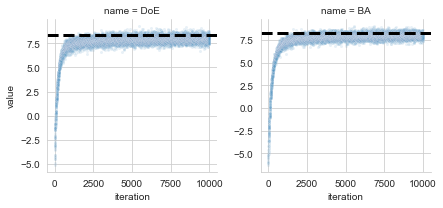

In [76]:
grid = sns.FacetGrid(pd.DataFrame(log), col='name', sharey=False, sharex=True, col_wrap=4)


grid.map(sns.lineplot, 'iteration', 'value', marker='.', alpha=0.1, linewidth=0)

for ax in grid.axes:
    ax.axhline(y=true_mi, ls='--', color='k', linewidth=3)
    # ax.set_ylim(0, 20)

# plt.ylim(0, 1)

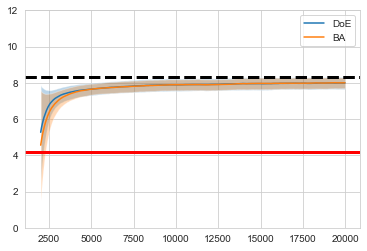

In [77]:
pd_log =pd.DataFrame(log)

summary = []

for name in pd_log['name'].unique():
    mi = pd_log[pd_log['name'] == name].sort_values('iteration')['value']

    # Apply a moving average
    mi_avg = mi.rolling(1000).mean()
    mi_std = mi.rolling(1000).std()

    summary.append(
        {
            'name': name,
            'bias': (mi_avg.values[-1]-true_mi.item())**2,
            'variance': mi_std.values[-1]**2,
        }
    )

    plt.plot(mi_avg, label=name)
    plt.fill_between(mi_avg.index, mi_avg - mi_std, mi_avg + mi_std, alpha=0.3)
    plt.axhline(y=true_mi, ls='--', color='k', linewidth=3)
    plt.axhline(y=np.log(batch_size), ls='-', color='r', linewidth=3)
    plt.ylim(0, 12)
    plt.legend()

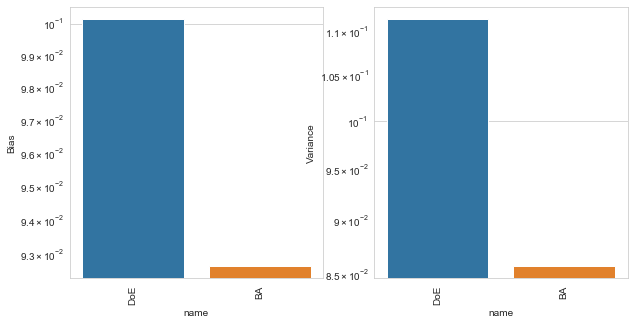

In [78]:
f, ax = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(data=pd.DataFrame(summary), x='name', y='bias', ax=ax[0])
sns.barplot(data=pd.DataFrame(summary), x='name', y='variance', ax=ax[1])

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)


ax[0].set_ylabel('Bias')
ax[1].set_ylabel('Variance')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
